For the final submission of the  notebook I removed all the fiftyone views. During work I worked with only one fiftyone window because it was buggy with google colab.

# Install Requirements

Install required packages.

In [1]:
%%capture
!uv pip install fiftyone==1.7.0 torch==2.6.0 torchvision==0.21 numpy==2.0.2 open-clip-torch==3.2.0

In [2]:
import fiftyone
import torch
import torchvision
import numpy

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


Install fiftyone plugins for data inspection.

In [3]:
# Plug-in to evaluate the performance of our classification models
!fiftyone plugins download \
    https://github.com/voxel51/fiftyone-plugins \
    --plugin-names @voxel51/evaluation

# Plug-in for image augmentations
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin

!fiftyone plugins download https://github.com/jacobmarks/clustering-plugin


Copying plugin '@voxel51/evaluation' to '/root/fiftyone/__plugins__/@voxel51/evaluation'

Copying plugin '@jacobmarks/albumentations_augmentation' to '/root/fiftyone/__plugins__/@jacobmarks/albumentations_augmentation'

Copying plugin '@jacobmarks/clustering' to '/root/fiftyone/__plugins__/@jacobmarks/clustering'


In [4]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from torch.utils.data import Dataset, ConcatDataset
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import albumentations as A
import cv2
import random
from typing import Optional, Dict, Tuple, Any

## Seed Management

In [5]:
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # OpenCV
    cv2.setRNGSeed(seed)

    # Albumentations (for data augmentation)
    try:
        A.seed_everything(seed)
    except AttributeError:
        # Older versions of albumentations
        pass

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(51)

# Additional reproducibility considerations:

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic behavior.

    Args:
        dataset: PyTorch Dataset instance
        batch_size: Batch size
        shuffle: Whether to shuffle data
        **kwargs: Additional DataLoader arguments

    Returns:
        Training DataLoader with reproducible behavior
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(51)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )



All random seeds set to 51 for reproducibility


# Prepare Dataset

## Create the Train and Validation Dataset

Load the Train/Validation Data

In [6]:
train_val_dataset = foz.load_zoo_dataset("mnist",
                                         split='train',
                                         dataset_name="mnist-train-val",
                                         persistent=True)

train_val_dataset.compute_metadata()
train_val_dataset.untag_samples(["train", "validation"])

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/mnist/train'
100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.2MB/s]

   0% |/------------|   207/60000 [103.7ms elapsed, 30.0s remaining, 2.0K samples/s] 

 100% |█████████████| 60000/60000 [23.8s elapsed, 0s remaining, 2.5K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [23.8s elapsed, 0s remaining, 2.5K samples/s]      


Dataset info written to '/root/fiftyone/mnist/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/mnist/info.json'


Loading 'mnist' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'train'


 100% |█████████████| 60000/60000 [37.5s elapsed, 0s remaining, 1.7K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [37.5s elapsed, 0s remaining, 1.7K samples/s]      


Dataset 'mnist-train-val' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-train-val' created


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 60000/60000 [23.9s elapsed, 0s remaining, 2.6K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [23.9s elapsed, 0s remaining, 2.6K samples/s]      


Create new train and test split

In [7]:
set_seeds(51)
# Create random 85%/15% split using tags
four.random_split(train_val_dataset,
                  {"train": 0.85, "validation": 0.15},
                  # The seed makes the split reproducible
                  seed=51)

# Verify the split by counting tags
tag_counts = train_val_dataset.count_sample_tags()
print(f"Tag counts after split: {tag_counts}")

# Separate validation and train FO datasets
train_dataset = train_val_dataset.match_tags("train").clone()
val_dataset = train_val_dataset.match_tags("validation").clone()

# Set names for FO datasets using the 'name' property
train_dataset.name = "mnist-training-set"
val_dataset.name = "mnist-validation-set"

# Define persistency
train_dataset.persistent = True
val_dataset.persistent = True

# Verify no overlap between train and validation
train_ids = set(train_dataset.values("id"))
val_ids = set(val_dataset.values("id"))
overlap = train_ids.intersection(val_ids)
overlap

All random seeds set to 51 for reproducibility
Tag counts after split: {'validation': 9000, 'train': 51000}


set()

## Create the Test Dataset

Load the Test Data

In [8]:
# We will load the test split from the dataset first
test_dataset = foz.load_zoo_dataset("mnist", split='test')

test_dataset.compute_metadata()


INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/mnist/test'
100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]

   2% |/------------|   209/10000 [100.8ms elapsed, 4.7s remaining, 2.1K samples/s] 

 100% |█████████████| 10000/10000 [4.4s elapsed, 0s remaining, 2.4K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [4.4s elapsed, 0s remaining, 2.4K samples/s]      


Dataset info written to '/root/fiftyone/mnist/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/mnist/info.json'


Loading 'mnist' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'test'


 100% |█████████████| 10000/10000 [5.8s elapsed, 0s remaining, 1.7K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [5.8s elapsed, 0s remaining, 1.7K samples/s]      


Dataset 'mnist-test' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-test' created


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 10000/10000 [4.2s elapsed, 0s remaining, 2.1K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [4.2s elapsed, 0s remaining, 2.1K samples/s]      


# Train the LeNet-5 Model

## Modern Definition of LeNet5

In [9]:
# Alternative modern version with ReLU and MaxPooling
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = Fun.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = Fun.relu(self.fc1(x))
        x = self.dropout(x)  # Add dropout for regularization
        x = self.fc2(x)

        return x

## Dataset


In [10]:
# Custom PyTorch Dataset class for MNIST training data
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset,
                 image_transforms=None,
                 label_map=None,
                 gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms
        self.label_map = label_map or {str(i): i for i in range(10)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str)

        return image, torch.tensor(label_idx, dtype=torch.long)

## Training

Normalize the pixel values to zero mean and unit variance.

In [11]:
def compute_stats_fiftyone(fiftyone_view):
    """
    Compute stats directly from FiftyOne using aggregations.
    Requires images to be loaded as arrays.
    """

    print("Computing image intensity statistics from FiftyOne view...")

    # Get all image filepaths
    filepaths = fiftyone_view.values("filepath")

    # Load all pixel values
    all_pixels = []

    for filepath in tqdm(filepaths):

        try:
            # Load image as grayscale array
            image = Image.open(filepath).convert('L')
            # Scale values to the range [0, 1]
            pixels = np.array(image, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

    # Concatenate all pixel values
    all_pixels = np.concatenate(all_pixels)

    # Compute statistics
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)

    print(f"Computed from {len(filepaths)} images")
    print(f"Total pixels: {len(all_pixels):,}")

    return mean, std

mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:08<00:00, 6250.75it/s]


Computed from 51000 images
Total pixels: 39,984,000


'Mean: 0.1318, Std: 0.3075'

In [12]:
# Map the string labels to numerical values (we need this for the PyTorch dataset)
dataset_classes = sorted(test_dataset.distinct("ground_truth.label"))
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}
label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

Create Train and Validation set with custom transformations

In [13]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

torch_train_set = CustomTorchImageDataset(train_dataset,
                                          label_map=label_map,
                                          image_transforms=image_transforms)

torch_val_set = CustomTorchImageDataset(val_dataset,
                                     label_map=label_map,
                                     image_transforms=image_transforms)

Create Dataloader for train and validation

In [14]:
# Define batch size (you can adjust this based on your GPU memory)
batch_size = 64
num_workers = os.cpu_count()  # Number of CPU cores

train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.


In [15]:
def train_epoch(model, train_loader, loss, optimizer):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss

def val_epoch(model, val_loader, loss):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = loss(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss

Train model and safe best model.

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ModernLeNet5().to(device)

ce_loss = nn.CrossEntropyLoss()

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)


# Ensure reproducibility for the training process
set_seeds(51) # You can change this number to get different results

num_epochs = 10
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, ce_loss, optimizer)
    val_loss = val_epoch(model, val_loader, ce_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

All random seeds set to 51 for reproducibility


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.96it/s]


Epoch 1/10 - Train Loss: 0.2165 - Val Loss: 0.0824
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.84it/s]


Epoch 2/10 - Train Loss: 0.0795 - Val Loss: 0.0575
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 41.92it/s]


Epoch 3/10 - Train Loss: 0.0624 - Val Loss: 0.0526
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.89it/s]


Epoch 4/10 - Train Loss: 0.0547 - Val Loss: 0.0544


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.88it/s]


Epoch 5/10 - Train Loss: 0.0485 - Val Loss: 0.0548


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.54it/s]


Epoch 6/10 - Train Loss: 0.0421 - Val Loss: 0.0577


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.73it/s]


Epoch 7/10 - Train Loss: 0.0385 - Val Loss: 0.0642


Validation: 100%|██████████| 141/141 [00:03<00:00, 41.28it/s]


Epoch 8/10 - Train Loss: 0.0394 - Val Loss: 0.0588


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.16it/s]


Epoch 9/10 - Train Loss: 0.0359 - Val Loss: 0.0646


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.80it/s]

Epoch 10/10 - Train Loss: 0.0334 - Val Loss: 0.0551


Visual inspection of the training process.

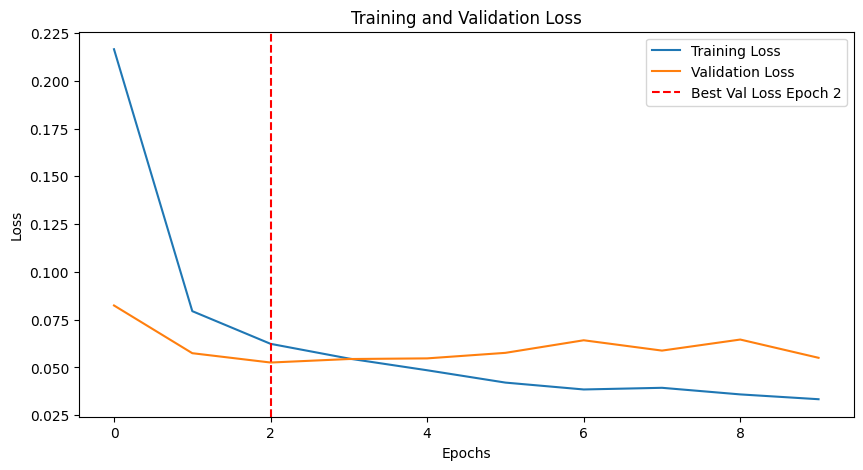

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses)

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.show()

## Apply model to Test set

Load the best model.

In [18]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'best_lenet.pth'

# Instantiate a new model with the same architecture
loaded_model = ModernLeNet5()

# Load the saved state dictionary into the new model instance
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /content/best_lenet.pth
Model is on device: cuda:0


Use it on the test set.

In [19]:
def predict(model, dataloader, device):
    model.eval()

    # Lists to store predictions and logits
    predictions = []
    all_logits = []

    # Run inference on the set
    with torch.inference_mode(): # Disable gradient calculation
        for images, _ in tqdm(dataloader):
            images = images.to(device)

            # Forward pass to get logits
            logits = model(images)
            all_logits.append(logits.cpu().numpy()) # Store logits

            # Get predicted class indices
            _, predicted = torch.max(logits.data, 1)
            predictions.extend(predicted.cpu().numpy()) # Store predictions

    # Concatenate logits from all batches
    all_logits = np.concatenate(all_logits, axis=0)

    return predictions, all_logits

def safe_classifications_for_dataset(dataset, predictions, all_logits, label_field):
    for i, sample in enumerate(dataset):
        # Get the predicted class index and corresponding class name
        predicted_idx = predictions[i]
        predicted_label = dataset_classes[predicted_idx]

        # Get logits for this sample
        sample_logits = all_logits[i]

        # Calculate confidence scores (softmax applied to logits)
        confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
        predicted_confidence = float(confidences[predicted_idx])

        # Create FiftyOne Classification object with prediction
        classification = fo.Classification(
            label=predicted_label,
            confidence=predicted_confidence,
            logits=sample_logits.tolist()  # Store raw logits
        )

        # Store the Classification object in the sample
        sample[label_field] = classification

        sample.save()

def apply_model_to_dataset(dataset, torch_dataset, model, label_field, device):
    inference_loader = torch.utils.data.DataLoader(
        torch_dataset,
        batch_size=batch_size,
        shuffle=False,    # CRITICAL: Must be False for ordered predictions
        num_workers=num_workers,
        pin_memory=True
    )
    print(f"DataLoader created successfully with {len(inference_loader)} batches.")

    print("Applying model to the dataset...")
    predictions, all_logits = predict(model, inference_loader, device)
    print("Inference on dataset complete.")
    print(f"Shape of collected logits: {all_logits.shape}")
    print(f"Number of collected predictions: {len(predictions)}")

    print("Storing predictions and logits as FiftyOne Classifications...")
    safe_classifications_for_dataset(dataset, predictions, all_logits, label_field)


In [20]:
## Apply best_model to the test set, store logits and confidence

# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(test_dataset,
                                      label_map=label_map, # Use the same label map as training
                                      image_transforms=image_transforms) # Use the same transforms

print("Applying best LeNet model to the test set...")

apply_model_to_dataset(test_dataset,
                       torch_test_set,
                       loaded_model,
                       "lenet_classification",
                       device)

Applying best LeNet model to the test set...
DataLoader created successfully with 157 batches.
Applying model to the dataset...


100%|██████████| 157/157 [00:04<00:00, 38.94it/s]


Inference on dataset complete.
Shape of collected logits: (10000, 10)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...


In [21]:
# Create a view showing only LeNet's misclassifications
misclassified_view = test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)
print(f"Misclassified samples: {len(misclassified_view)} samples")

lenet_evaluation_results = test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)


Misclassified samples: 128 samples
              precision    recall  f1-score   support

    0 - zero      0.993     0.996     0.994       980
     1 - one      0.990     0.996     0.993      1135
     2 - two      0.981     0.996     0.988      1032
   3 - three      0.988     0.992     0.990      1010
    4 - four      0.994     0.978     0.986       982
    5 - five      0.974     0.992     0.983       892
     6 - six      0.993     0.986     0.990       958
   7 - seven      0.980     0.988     0.984      1028
   8 - eight      0.995     0.974     0.984       974
    9 - nine      0.985     0.971     0.978      1009

    accuracy                          0.987     10000
   macro avg      0.987     0.987     0.987     10000
weighted avg      0.987     0.987     0.987     10000



In [22]:
lenet_evaluation_results.plot_confusion_matrix()

/usr/local/lib/python3.12/dist-packages/fiftyone/core/plots/plotly.py:1591: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.

/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




# Compute Hardness, Mistakeness and Mislabeld Samples

## Train

In [23]:
# Apply the trained model to training data for audit
apply_model_to_dataset(train_dataset,
                       torch_train_set,
                       loaded_model,
                       label_field="lenet_train_classification",
                       device=device)

fob.compute_hardness(train_dataset,
                     label_field='lenet_train_classification')

# Compute quality metrics on training data
fob.compute_mistakenness(train_dataset,
                         pred_field="lenet_train_classification",
                         label_field="ground_truth")

train_hardness_quantiles = train_dataset.quantiles(
    "hardness",
    [0.9, 0.95, 0.99]
)
train_highly_hard_samples = train_dataset.match(
    F("hardness") > train_hardness_quantiles[-1]
)
train_highly_hard_samples.tag_samples("highly_hard")

train_mistakenness_quantiles = train_dataset.quantiles(
    "mistakenness",
    [0.9, 0.95, 0.99]
)
train_highly_mistaken_samples = train_dataset.match(
    F("mistakenness") > train_mistakenness_quantiles[-1]
)
train_highly_mistaken_samples.tag_samples("highly_mistaken")

DataLoader created successfully with 797 batches.
Applying model to the dataset...


100%|██████████| 797/797 [00:20<00:00, 38.38it/s]


Inference on dataset complete.
Shape of collected logits: (51000, 10)
Number of collected predictions: 51000
Storing predictions and logits as FiftyOne Classifications...
Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |█████████████| 51000/51000 [1.7m elapsed, 0s remaining, 548.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [1.7m elapsed, 0s remaining, 548.6 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |█████████████| 51000/51000 [1.5m elapsed, 0s remaining, 497.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [1.5m elapsed, 0s remaining, 497.2 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


In [24]:
lenet_train_evaluation_results = train_dataset.evaluate_classifications(
    "lenet_train_classification",
    gt_field="ground_truth",
    eval_key="lenet_train_eval"
)

lenet_train_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.996     0.995     0.996      5006
     1 - one      0.990     0.996     0.993      5727
     2 - two      0.987     0.994     0.990      5078
   3 - three      0.990     0.992     0.991      5192
    4 - four      0.997     0.981     0.989      4931
    5 - five      0.984     0.996     0.990      4632
     6 - six      0.996     0.992     0.994      5053
   7 - seven      0.977     0.995     0.986      5369
   8 - eight      0.995     0.978     0.987      4979
    9 - nine      0.986     0.976     0.981      5033

    accuracy                          0.990     51000
   macro avg      0.990     0.990     0.990     51000
weighted avg      0.990     0.990     0.990     51000



In [25]:
mislabeled_train_samples = train_dataset.match(
    F("lenet_train_classification.label")!= F("ground_truth.label"))

## Validation

In [26]:

# Apply the trained model to validation data for audit
apply_model_to_dataset(val_dataset,
                       torch_val_set,
                       loaded_model,
                       label_field="lenet_validation_classification",
                       device=device)

fob.compute_hardness(val_dataset,
                     label_field='lenet_validation_classification')

fob.compute_mistakenness(val_dataset,
                         pred_field="lenet_validation_classification",
                         label_field="ground_truth")

val_hardness_quantiles = val_dataset.quantiles(
    "hardness",
    [0.9, 0.95, 0.99]
)
val_highly_hard_samples = val_dataset.match(
    F("hardness") > val_hardness_quantiles[-1]
)
val_highly_hard_samples.tag_samples("highly_hard")

val_mistakenness_quantiles = val_dataset.quantiles(
    "mistakenness",
    [0.9, 0.95, 0.99]
)
val_highly_mistaken_samples = val_dataset.match(
    F("mistakenness") > val_mistakenness_quantiles[-1]
)
val_highly_mistaken_samples.tag_samples("highly_mistaken")

DataLoader created successfully with 141 batches.
Applying model to the dataset...


100%|██████████| 141/141 [00:03<00:00, 39.54it/s]


Inference on dataset complete.
Shape of collected logits: (9000, 10)
Number of collected predictions: 9000
Storing predictions and logits as FiftyOne Classifications...
Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |███████████████| 9000/9000 [17.7s elapsed, 0s remaining, 454.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [17.7s elapsed, 0s remaining, 454.5 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |███████████████| 9000/9000 [16.0s elapsed, 0s remaining, 488.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [16.0s elapsed, 0s remaining, 488.4 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


In [27]:
lenet_validation_evaluation_results = val_dataset.evaluate_classifications(
    "lenet_validation_classification",
    gt_field="ground_truth",
    eval_key="lenet_validation_eval"
)

lenet_validation_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.989     0.996     0.992       917
     1 - one      0.985     0.997     0.991      1015
     2 - two      0.979     0.989     0.984       880
   3 - three      0.987     0.986     0.987       939
    4 - four      0.992     0.979     0.986       911
    5 - five      0.973     0.989     0.981       789
     6 - six      0.994     0.986     0.990       865
   7 - seven      0.975     0.987     0.981       896
   8 - eight      0.994     0.966     0.980       872
    9 - nine      0.980     0.974     0.977       916

    accuracy                          0.985      9000
   macro avg      0.985     0.985     0.985      9000
weighted avg      0.985     0.985     0.985      9000



In [28]:
mislabeled_val_samples = val_dataset.match(
    F("lenet_val_classification.label")!= F("ground_truth.label"))

## Test


In [29]:
# Compute hardness based on prediction uncertainty
fob.compute_hardness(test_dataset,
                     label_field='lenet_classification')

# Compute mistakenness to identify potential label errors
fob.compute_mistakenness(test_dataset,
                         pred_field="lenet_classification",
                         label_field="ground_truth")

test_hardness_quantiles = test_dataset.quantiles(
    "hardness",
    [0.9, 0.95, 0.99]
)
test_highly_hard_samples = test_dataset.match(
    F("hardness") > test_hardness_quantiles[-1]
)
test_highly_hard_samples.tag_samples("highly_hard")

test_mistakenness_quantiles = test_dataset.quantiles(
    "mistakenness",
    [0.9, 0.95, 0.99]
)
test_highly_mistaken_samples = test_dataset.match(
    F("mistakenness") > test_mistakenness_quantiles[-1]
)
test_highly_mistaken_samples.tag_samples("highly_mistaken")

Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |█████████████| 10000/10000 [19.4s elapsed, 0s remaining, 548.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [19.4s elapsed, 0s remaining, 548.0 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |█████████████| 10000/10000 [17.4s elapsed, 0s remaining, 620.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [17.4s elapsed, 0s remaining, 620.7 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


In [30]:
mislabeled_test_samples = test_dataset.match(
    F("lenet_classification.label")!= F("ground_truth.label"))

# Get Embedding Space

## Embedding Extraction Hook

In [31]:
## Extract Embeddings from LeNet Model Using PyTorch Hooks

def extract_lenet_embeddings(model, dataloader, device, layer_name='fc1'):
    """
    Extract embeddings from a specified layer of the LeNet model using PyTorch hooks.

    Args:
        model: Trained LeNet model
        dataloader: PyTorch DataLoader
        device: Device to run inference on
        layer_name: Name of the layer to extract embeddings from
                   Options: 'conv3', 'fc1', or 'fc2'

    Returns:
        numpy array of embeddings
    """
    # Dictionary to store the embeddings
    embeddings_dict = {}

    def hook_fn(module, input, output):
        """Hook function to capture layer outputs"""
        # Flatten the output if it's from conv layers
        if len(output.shape) > 2:
            embeddings_dict['embeddings'] = output.view(output.size(0), -1).cpu().detach()
        else:
            embeddings_dict['embeddings'] = output.cpu().detach()

    # Register the hook on the specified layer
    layer_map = {
        'conv3': model.conv3,  # Shape: (batch_size, 120, 1, 1) -> flattened to (batch_size, 120)
        'fc1': model.fc1,     # Shape: (batch_size, 84) - most common choice
        'fc2': model.fc2      # Shape: (batch_size, 10) - final logits
    }

    if layer_name not in layer_map:
        raise ValueError(f"Invalid layer_name. Choose from: {list(layer_map.keys())}")

    target_layer = layer_map[layer_name]
    hook_handle = target_layer.register_forward_hook(hook_fn)

    # Set model to evaluation mode
    model.eval()

    all_embeddings = []

    print(f"Extracting embeddings from {layer_name} layer...")

    with torch.inference_mode():
        for images, _ in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)

            # Forward pass (hook will capture the embeddings)
            _ = model(images)

            # Store the captured embeddings
            batch_embeddings = embeddings_dict['embeddings'].numpy()
            all_embeddings.append(batch_embeddings)

    # Remove the hook to clean up
    hook_handle.remove()

    # Concatenate all embeddings
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    print(f"Extracted embeddings shape: {final_embeddings.shape}")
    print(f"Embedding dimension: {final_embeddings.shape[1]}")

    return final_embeddings

## Embedding Extraction for Train

In [32]:
print("Creating non-shuffled DataLoader for embedding extraction...")

# Create a DataLoader specifically for inference with NO SHUFFLING
train_inference_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Non-shuffled inference DataLoader created with {len(train_inference_loader)} batches")

# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

train_lenet_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=train_inference_loader,  # ✅ Use non-shuffled loader
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

Creating non-shuffled DataLoader for embedding extraction...
Non-shuffled inference DataLoader created with 797 batches
Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 797/797 [00:22<00:00, 35.44it/s]

Extracted embeddings shape: (51000, 84)
Embedding dimension: 84


In [33]:
print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(train_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = train_lenet_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from train_dataset.")

# Verify storage
sample = train_dataset.first()
print(f"Sample LeNet embedding shape: {sample.lenet_embeddings.shape}")
print(f"Embedding type: {type(sample.lenet_embeddings)}")

# Persisting the change
train_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 51000/51000 [01:32<00:00, 552.05it/s]

LeNet embeddings stored successfully in samples from train_dataset.
Sample LeNet embedding shape: (84,)
Embedding type: <class 'numpy.ndarray'>


In [34]:
print("Computing similarity index based on LeNet embeddings...")

train_lenet_similarity_index = fob.compute_similarity(
    train_dataset,  # Using the training dataset
    embeddings="lenet_embeddings",  # Field containing the LeNet embeddings
    brain_key="lenet_cosine_similarity_index",  # Unique identifier for this similarity index
    backend="sklearn",  # Can also use "pinecone" for large datasets
    metric="cosine"  # Similarity metric
)

print(f"LeNet similarity index computed successfully!")

Computing similarity index based on LeNet embeddings...
LeNet similarity index computed successfully!


In [35]:
## Compute Uniqueness and Representativeness for LeNet Embeddings

print("Computing uniqueness scores based on LeNet embeddings...")
fob.compute_uniqueness(train_dataset, embeddings='lenet_embeddings')

print("Computing representativeness scores based on LeNet embeddings...")
fob.compute_representativeness(train_dataset, embeddings='lenet_embeddings')

print("Uniqueness and representativeness computation complete.")

Computing uniqueness scores based on LeNet embeddings...
Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness scores based on LeNet embeddings...
Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 51000 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 51000 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


Uniqueness and representativeness computation complete.


In [36]:
print("Creating 2D visualizations of LeNet embeddings...")

# PCA visualization
train_pca_viz_lenet = fob.compute_visualization(
    train_dataset,
    method="pca",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="pca_lenet_embeddings"
)

# UMAP visualization
train_umap_viz_lenet = fob.compute_visualization(
    train_dataset,
    method="umap",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="umap_lenet_embeddings"
)

print("2D visualizations created successfully.")

Creating 2D visualizations of LeNet embeddings...
Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Fri Nov 21 13:57:18 2025 Construct fuzzy simplicial set
Fri Nov 21 13:57:18 2025 Finding Nearest Neighbors
Fri Nov 21 13:57:18 2025 Building RP forest with 16 trees
Fri Nov 21 13:57:22 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Fri Nov 21 13:57:38 2025 Finished Nearest Neighbor Search
Fri Nov 21 13:57:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Nov 21 13:58:19 2025 Finished embedding
2D visualizations created successfully.


In [37]:
# Get quantiles for uniqueness based on LeNet embeddings
train_uniqueness_quantiles = train_dataset.quantiles("uniqueness", [0.999])
train_representativeness_quantiles = train_dataset.quantiles("representativeness", [0.999])

# Most unique samples (top 0.1% - these are often edge cases or outliers)
train_most_unique_samples = train_dataset.match(
                             F("uniqueness") > train_uniqueness_quantiles[-1])
train_most_unique_samples.tag_samples("most_unique")
print(f"Most unique samples: {len(train_most_unique_samples)} samples")

# Most representative samples (top 0.1% - these exemplify their clusters well)
train_most_representative_samples = train_dataset.match(
    F("representativeness") > train_representativeness_quantiles[-1])
train_most_representative_samples.tag_samples("most_representative")
print(f"Most representative samples: {len(train_most_representative_samples)} samples")

Most unique samples: 51 samples
Most representative samples: 51 samples


## Embedding Extraction for Validation

In [38]:
print("Creating non-shuffled DataLoader for embedding extraction...")

# Create a DataLoader specifically for inference with NO SHUFFLING
val_inference_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Non-shuffled inference DataLoader created with {len(val_inference_loader)} batches")

# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

val_lenet_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=val_inference_loader,  # ✅ Use non-shuffled loader
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

Creating non-shuffled DataLoader for embedding extraction...
Non-shuffled inference DataLoader created with 141 batches
Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 141/141 [00:03<00:00, 40.81it/s]

Extracted embeddings shape: (9000, 84)
Embedding dimension: 84


In [39]:
print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(val_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = val_lenet_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from val_dataset.")

# Persisting the change
val_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 9000/9000 [00:16<00:00, 547.58it/s]

LeNet embeddings stored successfully in samples from val_dataset.


In [40]:
print("Computing similarity index based on LeNet embeddings...")

val_lenet_similarity_index = fob.compute_similarity(
    val_dataset,  # Using the validation dataset
    embeddings="lenet_embeddings",  # Field containing the LeNet embeddings
    brain_key="lenet_cosine_similarity_index",  # Unique identifier for this similarity index
    backend="sklearn",  # Can also use "pinecone" for large datasets
    metric="cosine"  # Similarity metric
)

print(f"LeNet similarity index computed successfully!")

Computing similarity index based on LeNet embeddings...
LeNet similarity index computed successfully!


In [41]:
## Compute Uniqueness and Representativeness for LeNet Embeddings

print("Computing uniqueness scores based on LeNet embeddings...")
fob.compute_uniqueness(val_dataset, embeddings='lenet_embeddings')

print("Computing representativeness scores based on LeNet embeddings...")
fob.compute_representativeness(val_dataset, embeddings='lenet_embeddings')

print("Uniqueness and representativeness computation complete.")

Computing uniqueness scores based on LeNet embeddings...
Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness scores based on LeNet embeddings...
Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 9000 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 9000 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


Uniqueness and representativeness computation complete.


In [42]:
print("Creating 2D visualizations of LeNet embeddings...")

# PCA visualization
val_pca_viz_lenet = fob.compute_visualization(
    val_dataset,
    method="pca",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="pca_lenet_embeddings"
)

# UMAP visualization
val_umap_viz_lenet = fob.compute_visualization(
    val_dataset,
    method="umap",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="umap_lenet_embeddings"
)

print("2D visualizations created successfully.")

Creating 2D visualizations of LeNet embeddings...
Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Fri Nov 21 13:58:54 2025 Construct fuzzy simplicial set
Fri Nov 21 13:58:54 2025 Finding Nearest Neighbors
Fri Nov 21 13:58:54 2025 Building RP forest with 10 trees
Fri Nov 21 13:58:54 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Nov 21 13:58:55 2025 Finished Nearest Neighbor Search
Fri Nov 21 13:58:55 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Nov 21 13:59:07 2025 Finished embedding
2D visualizations created successfully.


We used a greater or equal check for the "representativeness" because there are no samples with a greater "representativeness" than the 99.9 quantile.



In [43]:
# Get quantiles for uniqueness based on LeNet embeddings
val_uniqueness_quantiles = val_dataset.quantiles("uniqueness", [0.999])
val_representativeness_quantiles = val_dataset.quantiles("representativeness", [0.999])

# Most unique samples (top 0.1% - these are often edge cases or outliers)
val_most_unique_samples = val_dataset.match(
                             F("uniqueness") > val_uniqueness_quantiles[-1])
val_most_unique_samples.tag_samples("most_unique")
print(f"Most unique samples: {len(val_most_unique_samples)} samples")

# Most representative samples (top 0.1% - these exemplify their clusters well)
val_most_representative_samples = val_dataset.match(
    F("representativeness") >= val_representativeness_quantiles[-1])
val_most_representative_samples.tag_samples("most_representative")
print(f"Most representative samples: {len(val_most_representative_samples)} samples")

Most unique samples: 9 samples
Most representative samples: 20 samples


## Embedding Extraction for Test

In [44]:
print("Creating non-shuffled DataLoader for embedding extraction...")

# Create a DataLoader specifically for inference with NO SHUFFLING
test_inference_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Non-shuffled inference DataLoader created with {len(test_inference_loader)} batches")

# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

test_lenet_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=test_inference_loader,  # ✅ Use non-shuffled loader
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

Creating non-shuffled DataLoader for embedding extraction...
Non-shuffled inference DataLoader created with 157 batches
Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 157/157 [00:05<00:00, 30.08it/s]

Extracted embeddings shape: (10000, 84)
Embedding dimension: 84


In [45]:
print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(test_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = test_lenet_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from test_dataset.")

# Persisting the change
test_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 10000/10000 [00:18<00:00, 537.81it/s]

LeNet embeddings stored successfully in samples from test_dataset.


In [46]:
print("Computing similarity index based on LeNet embeddings...")

test_lenet_similarity_index = fob.compute_similarity(
    test_dataset,  # Using the test dataset
    embeddings="lenet_embeddings",  # Field containing the LeNet embeddings
    brain_key="lenet_cosine_similarity_index",  # Unique identifier for this similarity index
    backend="sklearn",  # Can also use "pinecone" for large datasets
    metric="cosine"  # Similarity metric
)

print(f"LeNet similarity index computed successfully!")

Computing similarity index based on LeNet embeddings...
LeNet similarity index computed successfully!


In [47]:
## Compute Uniqueness and Representativeness for LeNet Embeddings

print("Computing uniqueness scores based on LeNet embeddings...")
fob.compute_uniqueness(test_dataset, embeddings='lenet_embeddings')

print("Computing representativeness scores based on LeNet embeddings...")
fob.compute_representativeness(test_dataset, embeddings='lenet_embeddings')

print("Uniqueness and representativeness computation complete.")

Computing uniqueness scores based on LeNet embeddings...
Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness scores based on LeNet embeddings...
Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 10000 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 10000 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


Uniqueness and representativeness computation complete.


In [48]:
print("Creating 2D visualizations of LeNet embeddings...")

# PCA visualization
test_pca_viz_lenet = fob.compute_visualization(
    test_dataset,
    method="pca",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="pca_lenet_embeddings"
)

# UMAP visualization
test_umap_viz_lenet = fob.compute_visualization(
    test_dataset,
    method="umap",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="umap_lenet_embeddings"
)

print("2D visualizations created successfully.")

Creating 2D visualizations of LeNet embeddings...
Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Fri Nov 21 13:59:46 2025 Construct fuzzy simplicial set
Fri Nov 21 13:59:46 2025 Finding Nearest Neighbors
Fri Nov 21 13:59:46 2025 Building RP forest with 10 trees
Fri Nov 21 13:59:46 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Nov 21 13:59:47 2025 Finished Nearest Neighbor Search
Fri Nov 21 13:59:47 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Nov 21 13:59:59 2025 Finished embedding
2D visualizations created successfully.


We used a greater or equal check for the "representativeness" because there are no samples with a greater "representativeness" than the 99.9 quantile.



In [49]:
# Get quantiles for uniqueness based on LeNet embeddings
test_uniqueness_quantiles = test_dataset.quantiles("uniqueness", [0.999])
test_representativeness_quantiles = test_dataset.quantiles("representativeness", [0.999])

# Most unique samples (top 0.1% - these are often edge cases or outliers)
test_most_unique_samples = test_dataset.match(
                             F("uniqueness") > test_uniqueness_quantiles[-1])
test_most_unique_samples.tag_samples("most_unique")
print(f"Most unique samples: {len(test_most_unique_samples)} samples")

# Most representative samples (top 0.1% - these exemplify their clusters well)
test_most_representative_samples = test_dataset.match(
    F("representativeness") >= test_representativeness_quantiles[-1])
test_most_representative_samples.tag_samples("most_representative")
print(f"Most representative samples: {len(test_most_representative_samples)} samples")

Most unique samples: 10 samples
Most representative samples: 20 samples


# Curation

## Train Set

In [50]:
# Focus on the intersection of difficult and misclassified samples
print(f"Number of highly mistaken samples (top 1%): {len(train_highly_mistaken_samples)}")
print(f"Number of highly hard samples (top 1%): {len(train_highly_hard_samples)}")
train_problematic_samples = train_dataset.select(
    set(train_highly_mistaken_samples.values("id")).intersection(
        set(train_highly_hard_samples.values("id"))
    )
)
train_problematic_samples.tag_samples("problematic")

train_problematic_samples_id = set(train_problematic_samples.values("id"))

print(f"Problematic samples: {len(train_problematic_samples)} samples")


Number of highly mistaken samples (top 1%): 510
Number of highly hard samples (top 1%): 510
Problematic samples: 196 samples


In [51]:
# Get the IDs of the misclassified samples
train_misclassified_sample_ids = set(mislabeled_train_samples.values("id"))

print(f"Total number of misclassified samples in the training set: {len(train_misclassified_sample_ids)}")

# Find the intersection of difficult samples and misclassified samples
train_intersection_difficult_misclassified_ids = train_problematic_samples_id.intersection(train_misclassified_sample_ids)

print(f"Number of samples that are both difficult and misclassified: {len(train_intersection_difficult_misclassified_ids)}")

# Create a FiftyOne view containing only these intersection samples
train_intersection_difficult_misclassified_samples = train_dataset.select(
    list(train_intersection_difficult_misclassified_ids))
train_intersection_difficult_misclassified_samples.tag_samples("difficult_misclassified")

Total number of misclassified samples in the training set: 522
Number of samples that are both difficult and misclassified: 196


Here we removed bad images. Bad images are images that look like other images (wrong ground truth) or are disturbed.

In [52]:
bad_train_images_paths = set([
    "/root/fiftyone/mnist/train/data/000636.jpg", # 5 that looks like 9 or 8
    "/root/fiftyone/mnist/train/data/000636.jpg", # 1 that looks like no number at all
    "/root/fiftyone/mnist/train/data/003031.jpg", # no number
    "/root/fiftyone/mnist/train/data/003693.jpg", # 7 that looks like 1
    "/root/fiftyone/mnist/train/data/005217.jpg", # 2 that is a gamma
    "/root/fiftyone/mnist/train/data/006348.jpg", # 3 that looks like 8
    "/root/fiftyone/mnist/train/data/007271.jpg", # 5 that looks like 6
    "/root/fiftyone/mnist/train/data/007600.jpg", # 1 one with pixel errors
    "/root/fiftyone/mnist/train/data/012079.jpg", # 1 but looks not like 1
    "/root/fiftyone/mnist/train/data/014009.jpg", # 8 that looks like 4
    "/root/fiftyone/mnist/train/data/014791.jpg", # 9 but could be 9 or 0 (think about it)
    "/root/fiftyone/mnist/train/data/015729.jpg", # 9 that looks like 4
    "/root/fiftyone/mnist/train/data/017959.jpg", # The Spaghetti Nine
    "/root/fiftyone/mnist/train/data/018505.jpg", # 4 but looks wrong (pixel error)
    "/root/fiftyone/mnist/train/data/020977.jpg", # 5 with pixel error
    "/root/fiftyone/mnist/train/data/021352.jpg", # 9 but hard to see
    "/root/fiftyone/mnist/train/data/022562.jpg", # 6 but looks different
    "/root/fiftyone/mnist/train/data/022608.jpg", # 4 that looks like 9
    "/root/fiftyone/mnist/train/data/025547.jpg", # 8 with missing parts
    "/root/fiftyone/mnist/train/data/026749.jpg", # 9 that looks like 4
    "/root/fiftyone/mnist/train/data/026941.jpg", # 6 not recognizable
    "/root/fiftyone/mnist/train/data/028358.jpg", # 0 not recognizable
    "/root/fiftyone/mnist/train/data/031186.jpg", # 2 not recognizable
    "/root/fiftyone/mnist/train/data/031728.jpg", # 1 with pixel error
    "/root/fiftyone/mnist/train/data/034329.jpg", # 8 not recognizable
    "/root/fiftyone/mnist/train/data/034772.jpg", # 0 looks like 9
    "/root/fiftyone/mnist/train/data/035247.jpg", # 8 looks like 2 or 9
    "/root/fiftyone/mnist/train/data/035325.jpg", # 4 not recognizable
    "/root/fiftyone/mnist/train/data/035711.jpg", # 1 not recognizable
    "/root/fiftyone/mnist/train/data/036935.jpg", # 9 looks like 4
    "/root/fiftyone/mnist/train/data/038053.jpg", # 4 looks like 9
    "/root/fiftyone/mnist/train/data/039356.jpg", # 8 not recognizable
    "/root/fiftyone/mnist/train/data/039424.jpg", # 9 not recognizable
    "/root/fiftyone/mnist/train/data/039684.jpg", # 0 looks like 6
    "/root/fiftyone/mnist/train/data/040977.jpg", # 1 looks like 2
    "/root/fiftyone/mnist/train/data/041157.jpg", # 0 looks like 6
    "/root/fiftyone/mnist/train/data/045918.jpg", # 9 with pixel error
    "/root/fiftyone/mnist/train/data/046079.jpg", # 7 looks like 1
    "/root/fiftyone/mnist/train/data/046467.jpg", # 7 but could also be 3
    "/root/fiftyone/mnist/train/data/047690.jpg", # 3 looks like 8
    "/root/fiftyone/mnist/train/data/047927.jpg", # 8 looks like 9
    "/root/fiftyone/mnist/train/data/048650.jpg", # 6 not recognizable
    "/root/fiftyone/mnist/train/data/050341.jpg", # 3 looks like 7
    "/root/fiftyone/mnist/train/data/050418.jpg", # 3 looks like 9
    "/root/fiftyone/mnist/train/data/050699.jpg", # 9 looks like 0
    "/root/fiftyone/mnist/train/data/051281.jpg", # 9 looks like 4
    "/root/fiftyone/mnist/train/data/051765.jpg", # 5 with missing parts
    "/root/fiftyone/mnist/train/data/052915.jpg", # 5 that looks like 9
    "/root/fiftyone/mnist/train/data/052928.jpg", # 1 not recognizable
    "/root/fiftyone/mnist/train/data/052969.jpg", # 8 but looks like gamma
    "/root/fiftyone/mnist/train/data/053624.jpg", # 9 with pixel error
    "/root/fiftyone/mnist/train/data/053639.jpg", # 5 not recognizable
    "/root/fiftyone/mnist/train/data/054037.jpg", # 9 but looks like 4
    "/root/fiftyone/mnist/train/data/054835.jpg", # 2 with missing parts
    "/root/fiftyone/mnist/train/data/054951.jpg", # 8 with missing parts
    "/root/fiftyone/mnist/train/data/056398.jpg", # 0 not recognizable
    "/root/fiftyone/mnist/train/data/056515.jpg", # 2 not recognizable
    "/root/fiftyone/mnist/train/data/058023.jpg", # 1 not recognizable
    "/root/fiftyone/mnist/train/data/058065.jpg", # 3 that looks like 9
    # from the example notebook
    "/root/fiftyone/mnist/train/data/002902.jpg",
    "/root/fiftyone/mnist/train/data/003693.jpg",
    "/root/fiftyone/mnist/train/data/035247.jpg",
    "/root/fiftyone/mnist/train/data/018383.jpg",
    "/root/fiftyone/mnist/train/data/033507.jpg",
    "/root/fiftyone/mnist/train/data/039424.jpg",
    "/root/fiftyone/mnist/train/data/025547.jpg",
    "/root/fiftyone/mnist/train/data/047218.jpg",
    "/root/fiftyone/mnist/train/data/001921.jpg",
    "/root/fiftyone/mnist/train/data/004477.jpg",
    "/root/fiftyone/mnist/train/data/050606.jpg",
    "/root/fiftyone/mnist/train/data/030050.jpg",
    "/root/fiftyone/mnist/train/data/024614.jpg",
    "/root/fiftyone/mnist/train/data/014583.jpg",
    "/root/fiftyone/mnist/train/data/034521.jpg",
    "/root/fiftyone/mnist/train/data/050995.jpg",
    "/root/fiftyone/mnist/train/data/004477.jpg",
    "/root/fiftyone/mnist/train/data/033319.jpg",
    "/root/fiftyone/mnist/train/data/034405.jpg"
    "/root/fiftyone/mnist/train/data/007260.jpg",
    "/root/fiftyone/mnist/train/data/001401.jpg",
    "/root/fiftyone/mnist/train/data/002149.jpg",
    "/root/fiftyone/mnist/train/data/000903.jpg",
    "/root/fiftyone/mnist/train/data/001921.jpg",
    # others to exclude
    "/root/fiftyone/mnist/train/data/005104.jpg", # 2 that looks like 9
])

train_samples_to_exclude = train_dataset.match(
    fo.ViewField("filepath").is_in(bad_train_images_paths)
)
train_samples_to_exclude.tag_samples("exclude")
train_sample_ids_to_exclude = train_samples_to_exclude.values("id")

In [53]:
new_train_dataset = train_dataset.exclude(train_sample_ids_to_exclude).clone()

print(f"Original train_dataset has {len(train_dataset)} samples.")
print(f"Excluding {len(train_sample_ids_to_exclude)} samples.")
print(f"New train_dataset view has {len(new_train_dataset)} samples.")

new_train_dataset.name = "cleaned-up-mnist-training-set"
new_train_dataset.persistent = True
print(f"New persistent dataset created with {len(new_train_dataset)} samples.")

Original train_dataset has 51000 samples.
Excluding 75 samples.
New train_dataset view has 50925 samples.
New persistent dataset created with 50925 samples.


In [54]:
# To work with this view in PyTorch, create a CustomTorchImageDataset from it
new_torch_train_set = CustomTorchImageDataset(
    new_train_dataset,  # Changed from new_train_set to new_train_dataset
    label_map=label_map, # Use the same label map
    image_transforms=image_transforms # Use the same transforms
)

print(f"New PyTorch dataset created from the filtered view with {len(new_torch_train_set)} samples.")

New PyTorch dataset created from the filtered view with 50925 samples.


## Validation Set

In [55]:
# Focus on the intersection of difficult and misclassified samples
print(f"Number of highly mistaken samples (top 1%): {len(val_highly_mistaken_samples)}")
print(f"Number of highly hard samples (top 1%): {len(val_highly_hard_samples)}")
val_problematic_samples = val_dataset.select(
    set(val_highly_mistaken_samples.values("id")).intersection(
        set(val_highly_hard_samples.values("id"))
    )
)
val_problematic_samples.tag_samples("problematic")

val_problematic_samples_id = set(val_problematic_samples.values("id"))

print(f"Problematic samples: {len(val_problematic_samples)} samples")


Number of highly mistaken samples (top 1%): 90
Number of highly hard samples (top 1%): 90
Problematic samples: 5 samples


In [56]:
# Get the IDs of the misclassified samples
val_misclassified_sample_ids = set(mislabeled_val_samples.values("id"))

print(f"Total number of misclassified samples in the validation set: {len(val_misclassified_sample_ids)}")

# Find the intersection of difficult samples and misclassified samples
val_intersection_difficult_misclassified_ids = val_problematic_samples_id.intersection(val_misclassified_sample_ids)

print(f"Number of samples that are both difficult and misclassified: {len(val_intersection_difficult_misclassified_ids)}")

# Create a FiftyOne view containing only these intersection samples
val_intersection_difficult_misclassified_samples = val_dataset.select(
    list(val_intersection_difficult_misclassified_ids))
val_intersection_difficult_misclassified_samples.tag_samples("difficult_misclassified")

Total number of misclassified samples in the validation set: 9000
Number of samples that are both difficult and misclassified: 5


In [57]:
bad_val_images_paths = set([
    "/root/fiftyone/mnist/train/data/005130.jpg", # 2 that looks like 9
    "/root/fiftyone/mnist/train/data/008762.jpg", # 8 that looks like gamma
    "/root/fiftyone/mnist/train/data/031302.jpg", # 5 not recognizable
    "/root/fiftyone/mnist/train/data/056015.jpg", # 5 that looks like 8
    "/root/fiftyone/mnist/train/data/059702.jpg", # 5 not recognizable
])

val_samples_to_exclude = val_dataset.match(
    fo.ViewField("filepath").is_in(bad_val_images_paths)
)
val_samples_to_exclude.tag_samples("exclude")
val_sample_ids_to_exclude = val_samples_to_exclude.values("id")

In [58]:
new_val_dataset = val_dataset.exclude(val_sample_ids_to_exclude).clone()

print(f"Original val_dataset has {len(val_dataset)} samples.")
print(f"Excluding {len(val_sample_ids_to_exclude)} samples.")
print(f"New val_dataset view has {len(new_val_dataset)} samples.")

new_val_dataset.name = "cleaned-up-mnist-validation-set"
new_val_dataset.persistent = True
print(f"New persistent dataset created with {len(new_val_dataset)} samples.")

Original val_dataset has 9000 samples.
Excluding 5 samples.
New val_dataset view has 8995 samples.
New persistent dataset created with 8995 samples.


In [59]:
# To work with this view in PyTorch, create a CustomTorchImageDataset from it
new_torch_val_set = CustomTorchImageDataset(
    new_val_dataset,
    label_map=label_map, # Use the same label map
    image_transforms=image_transforms # Use the same transforms
)

print(f"New PyTorch dataset created from the filtered view with {len(new_torch_val_set)} samples.")

New PyTorch dataset created from the filtered view with 8995 samples.


## Test Set

In [60]:
# Focus on the intersection of difficult and misclassified samples
print(f"Number of highly mistaken samples (top 1%): {len(test_highly_mistaken_samples)}")
print(f"Number of highly hard samples (top 1%): {len(test_highly_hard_samples)}")
test_problematic_samples = test_dataset.select(
    set(test_highly_mistaken_samples.values("id")).intersection(
        set(test_highly_hard_samples.values("id"))
    )
)
test_problematic_samples.tag_samples("problematic")

test_problematic_samples_id = set(test_problematic_samples.values("id"))

print(f"Problematic samples: {len(test_problematic_samples)} samples")


Number of highly mistaken samples (top 1%): 100
Number of highly hard samples (top 1%): 100
Problematic samples: 23 samples


In [61]:
# Get the IDs of the misclassified samples
test_misclassified_sample_ids = set(mislabeled_test_samples.values("id"))

print(f"Total number of misclassified samples in the test set: {len(test_misclassified_sample_ids)}")

# Find the intersection of difficult samples and misclassified samples
test_intersection_difficult_misclassified_ids = test_problematic_samples_id.intersection(test_misclassified_sample_ids)

print(f"Number of samples that are both difficult and misclassified: {len(test_intersection_difficult_misclassified_ids)}")

# Create a FiftyOne view containing only these intersection samples
test_intersection_difficult_misclassified_samples = test_dataset.select(
    list(test_intersection_difficult_misclassified_ids))
test_intersection_difficult_misclassified_samples.tag_samples("difficult_misclassified")

Total number of misclassified samples in the test set: 128
Number of samples that are both difficult and misclassified: 23


In [62]:
bad_test_images_paths = set([
    "/root/fiftyone/mnist/test/data/000660.jpg", # 2 that looks like 1
    "/root/fiftyone/mnist/test/data/001233.jpg", # 9 that looks like 4
    "/root/fiftyone/mnist/test/data/001261.jpg", # 7 not recognizable
    "/root/fiftyone/mnist/test/data/001531.jpg", # 8 not recognizable
    "/root/fiftyone/mnist/test/data/002130.jpg", # 9 to slant
    "/root/fiftyone/mnist/test/data/003290.jpg", # 8 looks like 9
    "/root/fiftyone/mnist/test/data/003809.jpg", # 7 looks like 2
    "/root/fiftyone/mnist/test/data/004732.jpg", # 8 looks like 9
    "/root/fiftyone/mnist/test/data/006626.jpg", # 8 looks like gamma
    "/root/fiftyone/mnist/test/data/008528.jpg", # 6 not recognizable
    "/root/fiftyone/mnist/test/data/004572.jpg", # 6 not recognizable
])

test_samples_to_exclude = test_dataset.match(
    fo.ViewField("filepath").is_in(bad_test_images_paths)
)
test_samples_to_exclude.tag_samples("exclude")
test_sample_ids_to_exclude = test_samples_to_exclude.values("id")

In [63]:
new_test_dataset = test_dataset.exclude(test_sample_ids_to_exclude).clone()

print(f"Original test_dataset has {len(test_dataset)} samples.")
print(f"Excluding {len(test_sample_ids_to_exclude)} samples.")
print(f"New test_dataset view has {len(new_test_dataset)} samples.")

new_test_dataset.name = "cleaned-up-mnist-test-set"
new_test_dataset.persistent = True
print(f"New persistent dataset created with {len(new_test_dataset)} samples.")

Original test_dataset has 10000 samples.
Excluding 11 samples.
New test_dataset view has 9989 samples.
New persistent dataset created with 9989 samples.


In [64]:
# To work with this view in PyTorch, create a CustomTorchImageDataset from it
new_torch_test_set = CustomTorchImageDataset(
    new_test_dataset,
    label_map=label_map, # Use the same label map
    image_transforms=image_transforms # Use the same transforms
)

print(f"New PyTorch dataset created from the filtered view with {len(new_torch_test_set)} samples.")

New PyTorch dataset created from the filtered view with 9989 samples.


# Retrain Model

## AugmentedMNISTDataset

In [65]:
class AugmentedMNISTDataset(Dataset):
    """
    PyTorch dataset that applies augmentations to misclassified MNIST samples.
    Each sample can be augmented multiple times to create more training data.
    """

    def __init__(self, fiftyone_view,
                 label_map,
                 base_transforms,
                 augmentations=None,
                 augment_factor=5,
                 gt_field="ground_truth"):
        """
        Args:
            fiftyone_view: FiftyOne view of misclassified samples
            label_map: Mapping from string labels to indices
            base_transforms: Base PyTorch transforms (normalization, etc.)
            augmentations: Albumentations transform pipeline
            augment_factor: How many augmented versions to create per sample
        """
        self.image_paths = fiftyone_view.values("filepath")
        self.str_labels = fiftyone_view.values(f"{gt_field}.label")
        self.label_map = label_map
        self.base_transforms = base_transforms
        self.augmentations = augmentations
        self.augment_factor = augment_factor

        print(f"AugmentedMNISTDataset: {len(self.image_paths)} base samples")
        print(f"With augmentation factor {augment_factor}: {len(self)} total samples")

    def __len__(self):
        return len(self.image_paths) * (self.augment_factor + 1)  # +1 for original

    def __getitem__(self, idx):
        # Determine which base sample and whether to augment
        base_idx = idx // (self.augment_factor + 1)
        aug_idx = idx % (self.augment_factor + 1)

        # Load image
        image_path = self.image_paths[base_idx]
        image = Image.open(image_path).convert('L')

        # Convert to numpy for albumentations
        image_np = np.array(image, dtype=np.uint8)

        # Apply augmentation if not the first version (original)
        if aug_idx > 0 and self.augmentations is not None:
            augmented = self.augmentations(image=image_np)
            image_np = augmented['image']

        # Convert back to PIL for PyTorch transforms
        image = Image.fromarray(image_np).convert("L")

        # Apply base transforms (normalization, tensor conversion)
        if self.base_transforms:
            image = self.base_transforms(image)

        # Get label
        label_str = self.str_labels[base_idx]
        label_idx = self.label_map.get(label_str, -1)

        return image, torch.tensor(label_idx, dtype=torch.long)



## Define Augmentation

In [66]:
mnist_augmentations_1 = A.Compose([

    # Use Affine transform for shifting, scaling, and rotating
    A.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # ±10% translation
        scale=(0.9, 1.1),     # ±10% scaling
        rotate=(-5, 5),     # ±5° rotation
        p=0.8
    ),

    # Elastic deformations to simulate handwriting style variations
    A.ElasticTransform(
        alpha=20,             # Strength of distortion
        sigma=5,              # Smoothness of distortion
        border_mode=cv2.BORDER_CONSTANT,
        p=0.6
    ),

    # Mild perspective transformations
    A.Perspective(scale=(0.01, 0.03), p=0.2),

    # Mild grid distortion
    A.GridDistortion(num_steps=2, distort_limit=0.05, p=0.2),

])

## Create new trainings set



Find low confidence samples

In [67]:
# Calculate the 1th percentile (lowest percentile) of confidence scores for lenet_train_classification
confidence_quantiles = train_dataset.quantiles("lenet_train_classification.confidence", [0.01])
q10_confidence = confidence_quantiles[0]

print(f"The 1th percentile of confidence is: {q10_confidence:.4f}")

# Create a view of samples that were correctly classified AND have confidence <= 1th percentile
low_confidence_correct = train_dataset.match(
    (F("lenet_train_classification.label") == F("ground_truth.label")) &
    (F("lenet_train_classification.confidence") <= q10_confidence)
).sort_by("lenet_train_classification.confidence")

print(f"\nNumber of correctly classified samples with confidence <= {q10_confidence:.4f}: {len(low_confidence_correct)}")

The 1th percentile of confidence is: 0.6670

Number of correctly classified samples with confidence <= 0.6670: 288


In [68]:
dataset_name = "digit-samples-to-augment"

if dataset_name in fo.list_datasets():
    print(f"Dataset '{dataset_name}' already exists. Deleting it.")
    fo.delete_dataset(dataset_name)

# Always create a new dataset after deleting or if it didn't exist
dataset_to_augment = fo.Dataset(dataset_name)

for sample in mislabeled_train_samples:
    dataset_to_augment.add_sample(sample)

for sample in train_most_unique_samples:
    dataset_to_augment.add_sample(sample)

for sample in train_most_representative_samples:
    dataset_to_augment.add_sample(sample)

for sample in low_confidence_correct:
    dataset_to_augment.add_sample(sample)

dataset_to_augment.save()

In [69]:
# Filter out excluded samples
dataset_to_augment = dataset_to_augment.exclude(train_sample_ids_to_exclude).clone()

In [70]:
torch_augmented_dataset = AugmentedMNISTDataset(
    dataset_to_augment,
    label_map=label_map,
    base_transforms=image_transforms,
    augmentations=mnist_augmentations_1,
    augment_factor=9  # Create this number of augmented versions per input sample
)

print(f"Original misclassified samples: {len(mislabeled_train_samples)}")
print(f'')
print(f"Total augmented dataset size: {len(torch_augmented_dataset)}")



AugmentedMNISTDataset: 912 base samples
With augmentation factor 9: 9120 total samples
Original misclassified samples: 522

Total augmented dataset size: 9120


In [71]:
# Combine the original dataset with its augmentation
combined_dataset = ConcatDataset([new_torch_train_set, torch_augmented_dataset])
print(f"Combined dataset size: {len(combined_dataset)}")

Combined dataset size: 60045


In [72]:
# Create new DataLoader for combined dataset
combined_train_loader = create_deterministic_training_dataloader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)


print(f"Combined DataLoader has {len(combined_train_loader)} batches.")


Combined DataLoader has 939 batches.


## Fine-Tunning

We create a new validation loader because we removed validation images.

In [73]:
new_val_loader = torch.utils.data.DataLoader(
    new_torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print(f"New validation dataloader has {len(new_val_loader)} batches")

New validation dataloader has 141 batches


In [74]:
## Load Best Model for Retraining

# Ensure reproducibility for the retraining process
set_seeds(51) # Use the same seed as initial training for consistency

# Load the previously saved best model
best_model_path = Path(os.getcwd()) / 'best_lenet.pth'
retrain_model = ModernLeNet5()
retrain_model.load_state_dict(torch.load(best_model_path, map_location=device))
retrain_model = retrain_model.to(device)

print(f"Loaded best model from {best_model_path} for retraining")

# Use a lower learning rate for fine-tuning
retrain_optimizer = Adam(retrain_model.parameters(), lr=0.0001,
                       weight_decay=1e-3)
# 10x stronger regularization
# 30x smaller learning rate

print("\nStarting retraining with augmented data...")

retrain_epochs = 15
retrain_losses = []
retrain_val_losses = []

# Track the best validation loss during retraining
best_retrain_val_loss = float('inf')
retrain_model_save_path = Path(os.getcwd()) / 'retrained_lenet.pth'

for epoch in range(retrain_epochs):
    print(f"\n--- Retrain Epoch {epoch+1}/{retrain_epochs} ---")

    # Training phase
    retrain_model.train()
    batch_losses = []

    for images, labels in tqdm(combined_train_loader, desc="Retraining"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = retrain_model(images)
        loss_value = ce_loss(logits, labels)

        # Backward pass
        retrain_optimizer.zero_grad()
        loss_value.backward()
        retrain_optimizer.step()

        batch_losses.append(loss_value.item())

    train_loss = np.mean(batch_losses)
    retrain_losses.append(train_loss)

    # Validation phase
    retrain_model.eval()
    val_batch_losses = []

    with torch.inference_mode():
        for images, labels in tqdm(new_val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)

            logits = retrain_model(images)
            loss_value = ce_loss(logits, labels)
            val_batch_losses.append(loss_value.item())

    val_loss = np.mean(val_batch_losses)
    retrain_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model during retraining
    if val_loss < best_retrain_val_loss:
        best_retrain_val_loss = val_loss
        torch.save(retrain_model.state_dict(), retrain_model_save_path)
        print("✓ Saved improved retrained model")

print(f"\nRetraining complete! Best model saved to {retrain_model_save_path}")




All random seeds set to 51 for reproducibility
Loaded best model from /content/best_lenet.pth for retraining

Starting retraining with augmented data...

--- Retrain Epoch 1/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.41it/s]


Epoch 1: Train Loss: 0.2583, Val Loss: 0.0395
✓ Saved improved retrained model

--- Retrain Epoch 2/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.12it/s]


Epoch 2: Train Loss: 0.2070, Val Loss: 0.0403

--- Retrain Epoch 3/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 29.01it/s]


Epoch 3: Train Loss: 0.1850, Val Loss: 0.0383
✓ Saved improved retrained model

--- Retrain Epoch 4/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.46it/s]


Epoch 4: Train Loss: 0.1707, Val Loss: 0.0374
✓ Saved improved retrained model

--- Retrain Epoch 5/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.41it/s]


Epoch 5: Train Loss: 0.1568, Val Loss: 0.0361
✓ Saved improved retrained model

--- Retrain Epoch 6/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 35.28it/s]


Epoch 6: Train Loss: 0.1511, Val Loss: 0.0370

--- Retrain Epoch 7/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 30.48it/s]


Epoch 7: Train Loss: 0.1438, Val Loss: 0.0358
✓ Saved improved retrained model

--- Retrain Epoch 8/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.64it/s]


Epoch 8: Train Loss: 0.1341, Val Loss: 0.0375

--- Retrain Epoch 9/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 36.25it/s]


Epoch 9: Train Loss: 0.1277, Val Loss: 0.0356
✓ Saved improved retrained model

--- Retrain Epoch 10/15 ---


Validation: 100%|██████████| 141/141 [00:05<00:00, 24.87it/s]


Epoch 10: Train Loss: 0.1240, Val Loss: 0.0367

--- Retrain Epoch 11/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.69it/s]


Epoch 11: Train Loss: 0.1179, Val Loss: 0.0361

--- Retrain Epoch 12/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.43it/s]


Epoch 12: Train Loss: 0.1141, Val Loss: 0.0363

--- Retrain Epoch 13/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 30.97it/s]


Epoch 13: Train Loss: 0.1096, Val Loss: 0.0362

--- Retrain Epoch 14/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 36.85it/s]


Epoch 14: Train Loss: 0.1047, Val Loss: 0.0364

--- Retrain Epoch 15/15 ---


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.34it/s]

Epoch 15: Train Loss: 0.1021, Val Loss: 0.0343
✓ Saved improved retrained model

Retraining complete! Best model saved to /content/retrained_lenet.pth


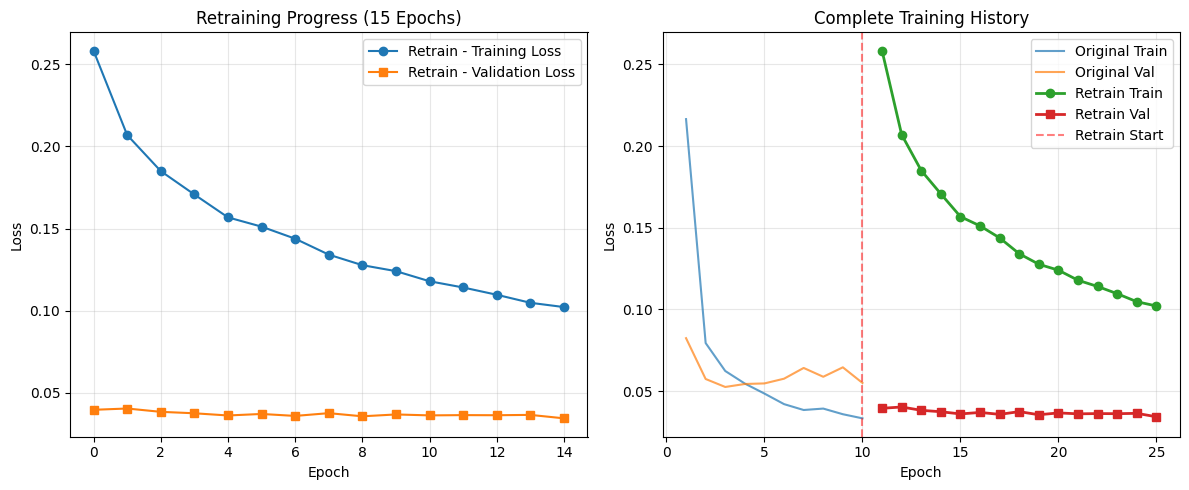

In [75]:
plt.figure(figsize=(12, 5))

# Plot retraining losses
plt.subplot(1, 2, 1)
plt.plot(retrain_losses, label='Retrain - Training Loss', marker='o')
plt.plot(retrain_val_losses, label='Retrain - Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Retraining Progress ({retrain_epochs} Epochs)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot comparison with original training (if we have the data)
plt.subplot(1, 2, 2)
if 'train_losses' in locals() and 'val_losses' in locals():
    epochs_orig = range(1, len(train_losses) + 1)
    epochs_retrain = range(len(train_losses) + 1, len(train_losses) + 1 + len(retrain_losses))

    plt.plot(epochs_orig, train_losses, label='Original Train', alpha=0.7)
    plt.plot(epochs_orig, val_losses, label='Original Val', alpha=0.7)
    plt.plot(epochs_retrain, retrain_losses, label='Retrain Train', marker='o', linewidth=2)
    plt.plot(epochs_retrain, retrain_val_losses, label='Retrain Val', marker='s', linewidth=2)

    plt.axvline(x=len(train_losses), color='red', linestyle='--', alpha=0.5, label='Retrain Start')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Complete Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Apply to test set

In [76]:
print("\nApplying retrained model to test set...")

# Load the best retrained model
final_model = ModernLeNet5()
final_model.load_state_dict(torch.load(retrain_model_save_path, map_location=device))
final_model = final_model.to(device)
final_model.eval()

apply_model_to_dataset(test_dataset,
                       torch_test_set,
                       final_model,
                       label_field="retrained_lenet_classification",
                       device=device)

print("Retrained model predictions stored successfully!")




Applying retrained model to test set...
DataLoader created successfully with 157 batches.
Applying model to the dataset...


100%|██████████| 157/157 [00:04<00:00, 32.47it/s]


Inference on dataset complete.
Shape of collected logits: (10000, 10)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...
Retrained model predictions stored successfully!


In [77]:
print("\nEvaluating retrained model performance...")

# Evaluate retrained model
retrained_evaluation_results = test_dataset.evaluate_classifications(
    "retrained_lenet_classification",
    gt_field="ground_truth",
    eval_key="retrained_lenet_eval"
)

print("\n" + "="*60)
print("RETRAINED MODEL EVALUATION RESULTS")
print("="*60)
retrained_evaluation_results.print_report(digits=4)




Evaluating retrained model performance...

RETRAINED MODEL EVALUATION RESULTS
              precision    recall  f1-score   support

    0 - zero     0.9969    0.9949    0.9959       980
     1 - one     0.9947    0.9903    0.9925      1135
     2 - two     0.9951    0.9884    0.9917      1032
   3 - three     0.9863    0.9960    0.9911      1010
    4 - four     0.9859    0.9959    0.9909       982
    5 - five     0.9899    0.9899    0.9899       892
     6 - six     0.9958    0.9885    0.9921       958
   7 - seven     0.9932    0.9893    0.9912      1028
   8 - eight     0.9878    0.9979    0.9928       974
    9 - nine     0.9880    0.9832    0.9856      1009

    accuracy                         0.9914     10000
   macro avg     0.9914    0.9914    0.9914     10000
weighted avg     0.9914    0.9914    0.9914     10000



In [78]:
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Get metrics for both models
original_metrics = lenet_evaluation_results.metrics()
retrained_metrics = retrained_evaluation_results.metrics()

print(f"{'Metric':<20} {'Original':<12} {'Retrained':<12} {'Improvement':<12}")
print("-" * 56)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics_to_compare:
    if metric in original_metrics and metric in retrained_metrics:
        orig_val = original_metrics[metric]
        retrain_val = retrained_metrics[metric]
        improvement = retrain_val - orig_val

        print(f"{metric:<20} {orig_val:<12.4f} {retrain_val:<12.4f} {improvement:+.4f}")




PERFORMANCE COMPARISON
Metric               Original     Retrained    Improvement 
--------------------------------------------------------
accuracy             0.9872       0.9914       +0.0042
precision            0.9872       0.9914       +0.0042
recall               0.9872       0.9914       +0.0042


In [79]:
# Find samples that were misclassified before but correct now
originally_wrong = test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)

now_correct = originally_wrong.match(
    F("retrained_lenet_classification.label") == F("ground_truth.label")
)

print(f"\nSamples fixed by retraining: {len(now_correct)}")

# Find samples that were correct before but wrong now
originally_correct = test_dataset.match(
    F("lenet_classification.label") == F("ground_truth.label")
)

now_wrong = originally_correct.match(
    F("retrained_lenet_classification.label") != F("ground_truth.label")
)

print(f"Samples broken by retraining: {len(now_wrong)}")

# Net improvement
net_improvement = len(now_correct) - len(now_wrong)
print(f"Net improvement in correct predictions: {net_improvement}")




Samples fixed by retraining: 81
Samples broken by retraining: 39
Net improvement in correct predictions: 42


Small Comparison for the curated test set

In [80]:
tmp_new_test_dataset = test_dataset.exclude(test_sample_ids_to_exclude).clone()

retrained_evaluation_results_new_test = tmp_new_test_dataset.evaluate_classifications(
    "retrained_lenet_classification",
    gt_field="ground_truth",
    eval_key="retrained_lenet_eval_new_test"
)

lenet_evaluation_results_new_test = tmp_new_test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval_new_test"
)

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Get metrics for both models
original_metrics = lenet_evaluation_results_new_test.metrics()
retrained_metrics = retrained_evaluation_results_new_test.metrics()

print(f"{'Metric':<20} {'Original':<12} {'Retrained':<12} {'Improvement':<12}")
print("-" * 56)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics_to_compare:
    if metric in original_metrics and metric in retrained_metrics:
        orig_val = original_metrics[metric]
        retrain_val = retrained_metrics[metric]
        improvement = retrain_val - orig_val

        print(f"{metric:<20} {orig_val:<12.4f} {retrain_val:<12.4f} {improvement:+.4f}")



PERFORMANCE COMPARISON
Metric               Original     Retrained    Improvement 
--------------------------------------------------------
accuracy             0.9883       0.9919       +0.0036
precision            0.9883       0.9919       +0.0036
recall               0.9883       0.9919       +0.0036


# IDK Classifier

## Create new Dataset

In [81]:
idk_train_dataset = train_dataset.clone()

for sample in tqdm(idk_train_dataset, desc="Set new ground truth for train: "):
    new_label = sample.ground_truth.label

    # override label with "idk" for excluded IDs
    if sample.id in train_sample_ids_to_exclude:
        new_label = "idk"

    sample["idk_ground_truth"] = fo.Classification(label=new_label)
    sample.save()

idk_train_dataset.save()

Set new ground truth for train: 100%|██████████| 51000/51000 [01:50<00:00, 460.91it/s]


In [82]:
idk_val_dataset = val_dataset.clone()

for sample in tqdm(idk_val_dataset, desc="Set new ground truth for val: "):
    new_label = sample.ground_truth.label

    # override label with "idk" for excluded IDs
    if sample.id in val_sample_ids_to_exclude:
        new_label = "idk"

    sample["idk_ground_truth"] = fo.Classification(label=new_label)
    sample.save()

idk_val_dataset.save()

Set new ground truth for val: 100%|██████████| 9000/9000 [00:19<00:00, 452.93it/s]


In [83]:
idk_test_dataset  = test_dataset.clone()

for sample in tqdm(idk_test_dataset, desc="Set new ground truth for test: "):
    new_label = sample.ground_truth.label

    # override label with "idk" for excluded IDs
    if sample.id in test_sample_ids_to_exclude:
        new_label = "idk"

    sample["idk_ground_truth"] = fo.Classification(label=new_label)
    sample.save()

idk_test_dataset.save()

Set new ground truth for test: 100%|██████████| 10000/10000 [00:25<00:00, 399.79it/s]


In [84]:
# Map the string labels to numerical values (we need this for the PyTorch dataset)
# We change the dataset_classes here which affects previous functions
dataset_classes = sorted(idk_test_dataset.distinct("idk_ground_truth.label"))
idk_label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}
idk_label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9,
 'idk': 10}

We want to augment the idk samples because of class inbalance.

In [85]:
set_seeds(51)

idk_train_set_without_idk = idk_train_dataset.match(
    fo.ViewField("idk_ground_truth.label") != "idk"
)

idk_train_set_with_idk = idk_train_dataset.match(
    fo.ViewField("idk_ground_truth.label") == "idk"
)

idk_torch_train_set_without_idk = CustomTorchImageDataset(idk_train_set_without_idk,
                                          label_map=idk_label_map,
                                          image_transforms=image_transforms,
                                          gt_field="idk_ground_truth")

idk_torch_train_set_with_idk = AugmentedMNISTDataset(
    idk_train_set_with_idk,
    label_map=idk_label_map,
    base_transforms=image_transforms,
    augmentations=mnist_augmentations_1,
    augment_factor=9,  # Create this number of augmented versions per input sample
    gt_field="idk_ground_truth"
)

idk_torch_train_set = ConcatDataset([idk_torch_train_set_without_idk, idk_torch_train_set_with_idk])
print(f"Combined dataset size: {len(idk_torch_train_set)}")

idk_torch_val_set = CustomTorchImageDataset(idk_val_dataset,
                                     label_map=idk_label_map,
                                     image_transforms=image_transforms,
                                     gt_field="idk_ground_truth")

All random seeds set to 51 for reproducibility
AugmentedMNISTDataset: 75 base samples
With augmentation factor 9: 750 total samples
Combined dataset size: 51675


In [86]:
idk_train_loader = create_deterministic_training_dataloader(
    idk_torch_train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

idk_val_loader = torch.utils.data.DataLoader(
    idk_torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train DataLoader has {len(idk_train_loader)} batches.")
print(f"Validation DataLoader has {len(idk_val_loader)} batches.")

Train DataLoader has 808 batches.
Validation DataLoader has 141 batches.


## Training

In [87]:
device = "cuda" if torch.cuda.is_available() else "cpu"
idk_model = ModernLeNet5(num_classes=11).to(device)

ce_loss = nn.CrossEntropyLoss()

# Define the optimizer (variant of stochastic gradient descent)
idk_optimizer = Adam(idk_model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)


# Ensure reproducibility for the training process
set_seeds(51) # You can change this number to get different results

idk_num_epochs = 10
idk_train_losses = []
idk_val_losses = []

idk_best_val_loss = float('inf')
idk_best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

idk_model_save_path = path / 'best_idk.pth'

for epoch in range(idk_num_epochs):
    train_loss = train_epoch(idk_model, idk_train_loader, ce_loss, idk_optimizer)
    val_loss = val_epoch(idk_model, idk_val_loader, ce_loss)
    idk_train_losses.append(train_loss)
    idk_val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{idk_num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < idk_best_val_loss:
        idk_best_val_loss = val_loss
        idk_best_model = idk_model
        # Save the best model
        torch.save(idk_best_model.state_dict(), idk_model_save_path)
        print('Found and saved better weights for the model')

All random seeds set to 51 for reproducibility


Validation: 100%|██████████| 141/141 [00:05<00:00, 25.20it/s]


Epoch 1/10 - Train Loss: 0.2707 - Val Loss: 0.0779
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:04<00:00, 28.33it/s]


Epoch 2/10 - Train Loss: 0.1176 - Val Loss: 0.0721
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:04<00:00, 32.39it/s]


Epoch 3/10 - Train Loss: 0.0935 - Val Loss: 0.0644
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.83it/s]


Epoch 4/10 - Train Loss: 0.0837 - Val Loss: 0.0643
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.82it/s]


Epoch 5/10 - Train Loss: 0.0709 - Val Loss: 0.0645


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.89it/s]


Epoch 6/10 - Train Loss: 0.0647 - Val Loss: 0.0585
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.32it/s]


Epoch 7/10 - Train Loss: 0.0589 - Val Loss: 0.0736


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.32it/s]


Epoch 8/10 - Train Loss: 0.0564 - Val Loss: 0.0604


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.93it/s]


Epoch 9/10 - Train Loss: 0.0511 - Val Loss: 0.0790


Validation: 100%|██████████| 141/141 [00:03<00:00, 40.75it/s]

Epoch 10/10 - Train Loss: 0.0483 - Val Loss: 0.0718


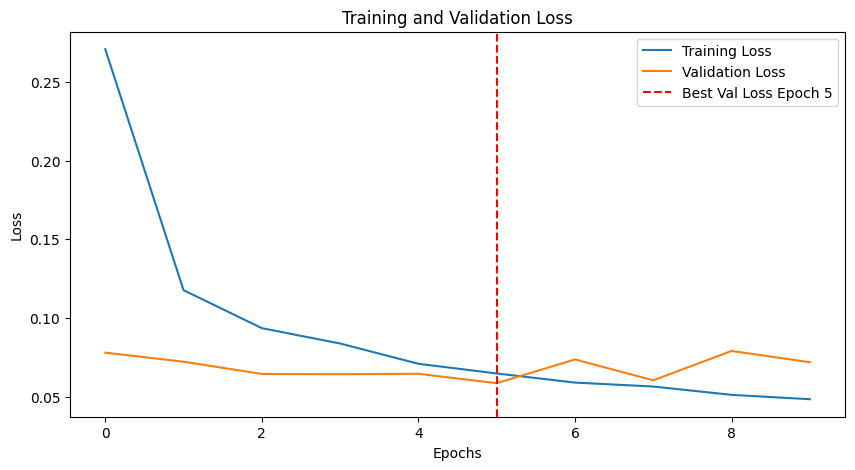

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(idk_train_losses, label='Training Loss')
plt.plot(idk_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
idk_best_epoch = np.argmin(idk_val_losses)

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=idk_best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {idk_best_epoch}')
plt.legend()

plt.show()

## Apply to test

In [89]:
# Define the path where the best model was saved
path = Path(os.getcwd())
idk_model_save_path = path / 'best_idk.pth'

# Instantiate a new model with the same architecture
idk_loaded_model = ModernLeNet5(num_classes=11)

# Load the saved state dictionary into the new model instance
device = "cuda" if torch.cuda.is_available() else "cpu"
idk_loaded_model.load_state_dict(torch.load(idk_model_save_path, map_location=device))

# Move the model to the device
idk_loaded_model = idk_loaded_model.to(device)

# Set the model to evaluation mode
idk_loaded_model.eval()

print(f"Model loaded successfully from {idk_model_save_path}")
print(f"Model is on device: {next(idk_loaded_model.parameters()).device}")

Model loaded successfully from /content/best_idk.pth
Model is on device: cuda:0


In [90]:
idk_torch_test_set = CustomTorchImageDataset(idk_test_dataset,
                                      label_map=idk_label_map, # Use the same label map as training
                                      image_transforms=image_transforms, # Use the same transforms
                                      gt_field="idk_ground_truth")

print("Applying best IDK-LeNet model to the test set...")

apply_model_to_dataset(idk_test_dataset,
                       idk_torch_test_set,
                       idk_loaded_model,
                       "idk_classification",
                       device)

Applying best IDK-LeNet model to the test set...
DataLoader created successfully with 157 batches.
Applying model to the dataset...


100%|██████████| 157/157 [00:05<00:00, 28.71it/s]


Inference on dataset complete.
Shape of collected logits: (10000, 11)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...


In [91]:
idk_misclassified_view = idk_test_dataset.match(
    F("idk_classification.label") != F("idk_ground_truth.label")
)
print(f"Misclassified samples: {len(idk_misclassified_view)} samples")

idk_evaluation_results = idk_test_dataset.evaluate_classifications(
    "idk_classification",
    gt_field="idk_ground_truth",
    eval_key="idk_eval")

idk_evaluation_results.print_report(digits=3)

Misclassified samples: 158 samples
              precision    recall  f1-score   support

    0 - zero      0.993     0.996     0.994       980
     1 - one      0.990     0.990     0.990      1135
     2 - two      0.994     0.978     0.986      1031
   3 - three      0.974     0.998     0.986      1010
    4 - four      0.992     0.982     0.987       981
    5 - five      0.994     0.976     0.985       892
     6 - six      0.993     0.987     0.990       957
   7 - seven      0.984     0.985     0.985      1026
   8 - eight      0.981     0.988     0.984       970
    9 - nine      0.990     0.966     0.978      1007
         idk      0.106     0.455     0.172        11

    accuracy                          0.984     10000
   macro avg      0.908     0.936     0.913     10000
weighted avg      0.987     0.984     0.986     10000



In [92]:
idk_evaluation_results.plot_confusion_matrix()

/usr/local/lib/python3.12/dist-packages/fiftyone/core/plots/plotly.py:1591: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



Find samples that got the idk class during inference.

In [93]:
idk_test_samples = idk_test_dataset.match(
    fo.ViewField("idk_classification.label") == "idk"
)

print(f"Found {len(idk_test_samples)} test samples with idk class")

Found 47 test samples with idk class


I inspected samples with idk label visually and some of them could be additionaly removed. Below is a list.

In [ ]:
idk_bad_test_samples = set([
    "/root/fiftyone/mnist/test/data/000097.jpg", # bad 1
    "/root/fiftyone/mnist/test/data/000718.jpg", # 0 that is similiar to 8
    "/root/fiftyone/mnist/test/data/001531.jpg", # bad 8
    "/root/fiftyone/mnist/test/data/001902.jpg", # 9 looks ike 4
    "/root/fiftyone/mnist/test/data/001941.jpg", # weird 5
    "/root/fiftyone/mnist/test/data/002019.jpg", # bad 1
    "/root/fiftyone/mnist/test/data/002130.jpg", # curved 9
    "/root/fiftyone/mnist/test/data/002294.jpg", # cut of 9
    "/root/fiftyone/mnist/test/data/002327.jpg", # 0 with missing parts
    "/root/fiftyone/mnist/test/data/004506.jpg", # bad 9
    "/root/fiftyone/mnist/test/data/004762.jpg", # bad 9
    "/root/fiftyone/mnist/test/data/006573.jpg", # 1 with missing parts
    "/root/fiftyone/mnist/test/data/006577.jpg", # 7 with missing parts
    "/root/fiftyone/mnist/test/data/006626.jpg", # 8 with missin parts
    "/root/fiftyone/mnist/test/data/008326.jpg", # 0 that looks like 8
    "/root/fiftyone/mnist/test/data/008409.jpg", # 8 with pixel error
    "/root/fiftyone/mnist/test/data/008523.jpg", # 8 with missing parts

    # other samples (found through other random seed)
    "/root/fiftyone/mnist/test/data/000660.jpg", # 2 that looks like a 1
    "/root/fiftyone/mnist/test/data/000741.jpg", # 4 that looks like a 9
    "/root/fiftyone/mnist/test/data/001738.jpg", # very bad 5
    "/root/fiftyone/mnist/test/data/001738.jpg", # very bad 1
    "/root/fiftyone/mnist/test/data/002294.jpg", # cut of 9
    "/root/fiftyone/mnist/test/data/003226.jpg", # 7 that looks like 9
    "/root/fiftyone/mnist/test/data/003458.jpg", # bad 1
    "/root/fiftyone/mnist/test/data/003727.jpg", # 4 that looks like 9
    "/root/fiftyone/mnist/test/data/003807.jpg", # bad 5
    "/root/fiftyone/mnist/test/data/004508.jpg", # bad 1
    "/root/fiftyone/mnist/test/data/004732.jpg", # 8 looks like 9
    "/root/fiftyone/mnist/test/data/006559.jpg", # 6 with misisng parts
    "/root/fiftyone/mnist/test/data/006561.jpg", # 9 with missing parts
    "/root/fiftyone/mnist/test/data/006573.jpg", # 1 with missing parts
    "/root/fiftyone/mnist/test/data/006577.jpg", # 7 with missing parts
    "/root/fiftyone/mnist/test/data/006626.jpg", # 7 with missing parts
    "/root/fiftyone/mnist/test/data/006573.jpg", # bad 1
    "/root/fiftyone/mnist/test/data/009541.jpg", # bad 1
    "/root/fiftyone/mnist/test/data/009670.jpg", # bad 4
])

Apply IDK-Classifier to train and val for curation. We need to redefine the trainset because of the augmentations.

In [95]:
_idk_torch_train_set = CustomTorchImageDataset(idk_train_dataset,
                                      label_map=idk_label_map, # Use the same label map as training
                                      image_transforms=image_transforms, # Use the same transforms
                                      gt_field="idk_ground_truth")

apply_model_to_dataset(idk_train_dataset,
                       _idk_torch_train_set,
                       idk_loaded_model,
                       "idk_classification",
                       device)

apply_model_to_dataset(idk_val_dataset,
                       idk_torch_val_set,
                       idk_loaded_model,
                       "idk_classification",
                       device)

DataLoader created successfully with 797 batches.
Applying model to the dataset...


100%|██████████| 797/797 [00:21<00:00, 37.91it/s]


Inference on dataset complete.
Shape of collected logits: (51000, 11)
Number of collected predictions: 51000
Storing predictions and logits as FiftyOne Classifications...
DataLoader created successfully with 141 batches.
Applying model to the dataset...


100%|██████████| 141/141 [00:03<00:00, 40.57it/s]


Inference on dataset complete.
Shape of collected logits: (9000, 11)
Number of collected predictions: 9000
Storing predictions and logits as FiftyOne Classifications...


In [96]:
idk_train_samples = idk_train_dataset.match(
    fo.ViewField("idk_classification.label") == "idk"
)

print(f"Found {len(idk_train_samples)} train samples with idk class")

Found 194 train samples with idk class


For the train samples I tagged them within fiftyone and exported their file paths. Here is the list of bad samples.

In [ ]:
idk_bad_train_samples = set([
    "/root/fiftyone/mnist/train/data/000636.jpg",
    "/root/fiftyone/mnist/train/data/001513.jpg",
    "/root/fiftyone/mnist/train/data/002149.jpg",
    "/root/fiftyone/mnist/train/data/002902.jpg",
    "/root/fiftyone/mnist/train/data/003031.jpg",
    "/root/fiftyone/mnist/train/data/003457.jpg",
    "/root/fiftyone/mnist/train/data/003693.jpg",
    "/root/fiftyone/mnist/train/data/004956.jpg",
    "/root/fiftyone/mnist/train/data/005053.jpg",
    "/root/fiftyone/mnist/train/data/005104.jpg",
    "/root/fiftyone/mnist/train/data/005217.jpg",
    "/root/fiftyone/mnist/train/data/006817.jpg",
    "/root/fiftyone/mnist/train/data/008679.jpg",
    "/root/fiftyone/mnist/train/data/009652.jpg",
    "/root/fiftyone/mnist/train/data/010288.jpg",
    "/root/fiftyone/mnist/train/data/011849.jpg",
    "/root/fiftyone/mnist/train/data/013429.jpg",
    "/root/fiftyone/mnist/train/data/014386.jpg",
    "/root/fiftyone/mnist/train/data/014575.jpg",
    "/root/fiftyone/mnist/train/data/014791.jpg",
    "/root/fiftyone/mnist/train/data/014897.jpg",
    "/root/fiftyone/mnist/train/data/015729.jpg",
    "/root/fiftyone/mnist/train/data/015770.jpg",
    "/root/fiftyone/mnist/train/data/018383.jpg",
    "/root/fiftyone/mnist/train/data/018505.jpg",
    "/root/fiftyone/mnist/train/data/020170.jpg",
    "/root/fiftyone/mnist/train/data/020977.jpg",
    "/root/fiftyone/mnist/train/data/021352.jpg",
    "/root/fiftyone/mnist/train/data/021602.jpg",
    "/root/fiftyone/mnist/train/data/022562.jpg",
    "/root/fiftyone/mnist/train/data/022608.jpg",
    "/root/fiftyone/mnist/train/data/025483.jpg",
    "/root/fiftyone/mnist/train/data/025547.jpg",
    "/root/fiftyone/mnist/train/data/025725.jpg",
    "/root/fiftyone/mnist/train/data/026073.jpg",
    "/root/fiftyone/mnist/train/data/026445.jpg",
    "/root/fiftyone/mnist/train/data/026472.jpg",
    "/root/fiftyone/mnist/train/data/026503.jpg",
    "/root/fiftyone/mnist/train/data/026853.jpg",
    "/root/fiftyone/mnist/train/data/026941.jpg",
    "/root/fiftyone/mnist/train/data/028369.jpg",
    "/root/fiftyone/mnist/train/data/030050.jpg",
    "/root/fiftyone/mnist/train/data/031186.jpg",
    "/root/fiftyone/mnist/train/data/031198.jpg",
    "/root/fiftyone/mnist/train/data/031311.jpg",
    "/root/fiftyone/mnist/train/data/031728.jpg",
    "/root/fiftyone/mnist/train/data/031739.jpg",
    "/root/fiftyone/mnist/train/data/033507.jpg",
    "/root/fiftyone/mnist/train/data/034329.jpg",
    "/root/fiftyone/mnist/train/data/034521.jpg",
    "/root/fiftyone/mnist/train/data/034708.jpg",
    "/root/fiftyone/mnist/train/data/034709.jpg",
    "/root/fiftyone/mnist/train/data/034772.jpg",
    "/root/fiftyone/mnist/train/data/035247.jpg",
    "/root/fiftyone/mnist/train/data/035325.jpg",
    "/root/fiftyone/mnist/train/data/035361.jpg",
    "/root/fiftyone/mnist/train/data/036935.jpg",
    "/root/fiftyone/mnist/train/data/037451.jpg",
    "/root/fiftyone/mnist/train/data/038053.jpg",
    "/root/fiftyone/mnist/train/data/039356.jpg",
    "/root/fiftyone/mnist/train/data/039424.jpg",
    "/root/fiftyone/mnist/train/data/040067.jpg",
    "/root/fiftyone/mnist/train/data/040467.jpg",
    "/root/fiftyone/mnist/train/data/040977.jpg",
    "/root/fiftyone/mnist/train/data/041515.jpg",
    "/root/fiftyone/mnist/train/data/047023.jpg",
    "/root/fiftyone/mnist/train/data/047218.jpg",
    "/root/fiftyone/mnist/train/data/047559.jpg",
    "/root/fiftyone/mnist/train/data/048650.jpg",
    "/root/fiftyone/mnist/train/data/050606.jpg",
    "/root/fiftyone/mnist/train/data/050699.jpg",
    "/root/fiftyone/mnist/train/data/051433.jpg",
    "/root/fiftyone/mnist/train/data/052625.jpg",
    "/root/fiftyone/mnist/train/data/052969.jpg",
    "/root/fiftyone/mnist/train/data/053081.jpg",
    "/root/fiftyone/mnist/train/data/053639.jpg",
    "/root/fiftyone/mnist/train/data/054037.jpg",
    "/root/fiftyone/mnist/train/data/055016.jpg",
    "/root/fiftyone/mnist/train/data/056398.jpg",
    "/root/fiftyone/mnist/train/data/056453.jpg",
    "/root/fiftyone/mnist/train/data/057077.jpg"
])

In [98]:
idk_val_samples = idk_val_dataset.match(
    fo.ViewField("idk_classification.label") == "idk"
)

print(f"Found {len(idk_val_samples)} val samples with idk class")

Found 37 val samples with idk class


In [99]:
idk_bad_val_samples = set([
    "/root/fiftyone/mnist/train/data/014143.jpg", # bad 9
    "/root/fiftyone/mnist/train/data/023869.jpg", # we found the Spaghetti Nine
    "/root/fiftyone/mnist/train/data/024251.jpg", # very bad 5
    "/root/fiftyone/mnist/train/data/029321.jpg", # very bad 1
    "/root/fiftyone/mnist/train/data/048976.jpg", # 2 with pixel error
    "/root/fiftyone/mnist/train/data/050523.jpg", # bad 9
])

## Curate Dataset with IDK Classifier

In [100]:
idk_train_samples_to_exclude = idk_train_dataset.match(
    fo.ViewField("filepath").is_in(idk_bad_train_samples)
)
idk_train_samples_to_exclude.tag_samples("exclude")

In [101]:
idk_val_samples_to_exclude = idk_val_dataset.match(
    fo.ViewField("filepath").is_in(idk_bad_val_samples)
)
idk_val_samples_to_exclude.tag_samples("exclude")

In [102]:
idk_test_samples_to_exclude = idk_test_dataset.match(
    fo.ViewField("filepath").is_in(idk_bad_test_samples)
)
idk_test_samples_to_exclude.tag_samples("exclude")

# Rest

# Export

I export the dataset with all samples but I tagged samples that could be removed with "exclude".

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
# Create a new merged dataset
dataset_name = "curated-mnist"

if dataset_name in fo.list_datasets():
    print(f"Dataset '{dataset_name}' already exists. Deleting it.")
    fo.delete_dataset(dataset_name)

merged_dataset = fo.Dataset(dataset_name)

# Add training samples with split tag
for sample in idk_train_dataset:
    sample.tags.append("train")
    merged_dataset.add_sample(sample)

print(f"Added {len(idk_train_dataset)} training samples to the merged dataset.")

# Add validation samples with split tag
for sample in idk_val_dataset:
    sample.tags.append("validation")
    merged_dataset.add_sample(sample)

print(f"Added {len(idk_val_dataset)} validation samples to the merged dataset.")

# Add test samples with split tag
for sample in idk_test_dataset:
    sample.tags.append("test")
    merged_dataset.add_sample(sample)

print(f"Added {len(idk_test_dataset)} test samples to the merged dataset.")

# Save the merged dataset
merged_dataset.persistent = True

print(f"Merged dataset created with {len(merged_dataset)} total samples")
print(f"Train samples: {len(merged_dataset.match_tags('train'))}")
print(f"Validation samples: {len(merged_dataset.match_tags('validation'))}")
print(f"Test samples: {len(merged_dataset.match_tags('test'))}")

Added 51000 training samples to the merged dataset.
Added 9000 validation samples to the merged dataset.
Added 10000 test samples to the merged dataset.
Merged dataset created with 70000 total samples
Train samples: 51000
Validation samples: 9000
Test samples: 10000


In [ ]:
# Save merged_dataset to disk using FiftyOneDataset type
export_dir = Path.cwd() / "drive" / "My Drive" / "Classification" / "curated_mnist_fiftyone"
export_dir.mkdir(parents=True, exist_ok=True)

merged_dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True  # This exports the actual image files along with metadata
)

print(f"Merged dataset exported to: {export_dir}")
print(f"Total samples exported: {len(merged_dataset)}")

Directory '/content/drive/My Drive/Classification/curated_mnist_fiftyone' already exists; export will be merged with existing files


Exporting samples...


INFO:fiftyone.utils.data.exporters:Exporting samples...


 100% |████████████████| 70000/70000 [11.7m elapsed, 0s remaining, 99.1 docs/s]       


INFO:eta.core.utils: 100% |████████████████| 70000/70000 [11.7m elapsed, 0s remaining, 99.1 docs/s]       


Merged dataset exported to: /content/drive/My Drive/Classification/curated_mnist_fiftyone
Total samples exported: 70000
